This notebook descrbies the selection of optimal k-mer length for the "bat" data sets for use in PORT-EK pipeline analysis.
To use it you will need the k-mer indices generated with PORTEKfind.py in the output/bat/[k]mer_indices directories, where [k] denotes the tested k-mer length value. 
To generate the indices as in the paper, you will need to run PORTEKfind.py on the appropriate data sets, previously downloaded in .fasta files, using the following commands from the main PORT-EK directory (the output directories must already exist):
 - python PORTEKfind.py input/bat/bat.fasta output/bat/[k]mer_indices/ --k [k] --group bat
 - python PORTEKfind.py input/bat/EPI_SET_240422qm.fasta output/bat/[k]mer_indices/ --k [k] --group hum

 substituting [k] for the tested k-mer lengths. To replicate the reuslts in the paper, you need to test k values of 5,7,9,11,15,19 and 25 for all sequences.  

You can also run generate_deer_kmers.sh scrpit which will automatically run PORTEKfind for all the options above, this is recommended only if your machine have at least 14 free CPUs.

1. Import necessary libraries and PORT-EK source code:

In [12]:
import sys
import json
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True

2. Declare data set specific definitions and functions, and a list of k-mer lengths to be tested.

In [8]:
#PORT-EK parameters
c = 0.01  # This is the conservation thershold used in k-mer rarity filter, other parameters are not used for optimal k selection.

#List of k values to test
k_list = [5,7,9,11,15,19,25]

#Data set specific definitions and functions

FREQ_COLS = ['bat_freq','hum_freq']
AVG_COLS = ['bat_avg','hum_avg']


3. Calculate k-mer specificity and efficiency for tested lengths. For definitions and discussion see [reference to our paper]

In [9]:
k_dict = {}
for k in k_list:
    print(f"Calculating specificity and efficiency of {k}-mers.")
    INPUT_PATH = f"../output/bat/{k}mer_indices"
    
    kmer_set = set()
    sample_list = []
    in_path = pathlib.Path(INPUT_PATH).glob('**/*')
    for filename in in_path:
        sample_list.append(filename.stem)
        with open(filename, mode="r") as in_file:
            temp_dict = json.load(in_file)
        kmer_set.update(temp_dict.keys())

    all_kmer_matrix = pd.DataFrame(0, index=list(kmer_set), columns=sample_list, dtype="uint8")
    bat_sample_idx = [sample for sample in all_kmer_matrix.columns if "bat" in sample]
    hum_sample_idx = [sample for sample in all_kmer_matrix.columns if "hum" in sample]
    print(f"Done importing sample names and {k}-mers sequences.")

    in_path = pathlib.Path(INPUT_PATH).glob('**/*')
    for filename in in_path:
        with open(filename, mode="r") as in_file:
            temp_dict = json.load(in_file)
        count_dict = {f"{filename.stem}":[len(pos) for pos in temp_dict.values()]}
        temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
        all_kmer_matrix.update(temp_df)

    bin_kmer_matrix = all_kmer_matrix > 0
    all_kmer_matrix['bat_freq'] = bin_kmer_matrix.loc[:,bat_sample_idx].mean(axis=1)
    all_kmer_matrix['hum_freq'] = bin_kmer_matrix.loc[:,hum_sample_idx].mean(axis=1)
    all_kmer_matrix['bat_avg'] = all_kmer_matrix.loc[:,bat_sample_idx].mean(axis=1)
    all_kmer_matrix['hum_avg'] = all_kmer_matrix.loc[:,hum_sample_idx].mean(axis=1)
    del bin_kmer_matrix

    if k*'A' in all_kmer_matrix.index:
        all_kmer_matrix = all_kmer_matrix.drop(k*'A')
    print(f"Done generating count matrix of all {k}-mers.")

    common_kmer_matrix = portek.filter_kmers(all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c)
    print(f"Done filerting out rare {k}-mers.")
    
    mean_count = common_kmer_matrix.iloc[:,:-6].mean(axis=None)
    common_kmer_matrix[['bat_avg_norm','hum_avg_norm']] = common_kmer_matrix[AVG_COLS]/mean_count
    common_kmer_matrix['bat_early_err_norm'] = common_kmer_matrix['bat_avg_norm']-common_kmer_matrix['hum_avg_norm']
    common_kmer_matrix['bat_RMSE_norm'] =  np.sqrt((common_kmer_matrix['bat_early_err_norm'])**2)

    specificity = common_kmer_matrix['bat_RMSE_norm'].quantile(q=0.99)
    efficiency = len(common_kmer_matrix)/len(all_kmer_matrix)
    k_dict[k] = (specificity, efficiency)

    del all_kmer_matrix, common_kmer_matrix
    print(f"Done calculating specificty and efficiency of {k}-mers.")

Calculating specificity and efficiency of 5-mers.
Done importing sample names and 5-mers sequences.
Done generating count matrix of all 5-mers.
Done filerting out rare 5-mers.
Done calculating specificty and efficiency of 5-mers.
Calculating specificity and efficiency of 7-mers.
Done importing sample names and 7-mers sequences.
Done generating count matrix of all 7-mers.
Done filerting out rare 7-mers.
Done calculating specificty and efficiency of 7-mers.
Calculating specificity and efficiency of 9-mers.
Done importing sample names and 9-mers sequences.
Done generating count matrix of all 9-mers.
Done filerting out rare 9-mers.
Done calculating specificty and efficiency of 9-mers.
Calculating specificity and efficiency of 11-mers.
Done importing sample names and 11-mers sequences.
Done generating count matrix of all 11-mers.
Done filerting out rare 11-mers.
Done calculating specificty and efficiency of 11-mers.
Calculating specificity and efficiency of 15-mers.
Done importing sample na

4. Plot specificity and efficiency

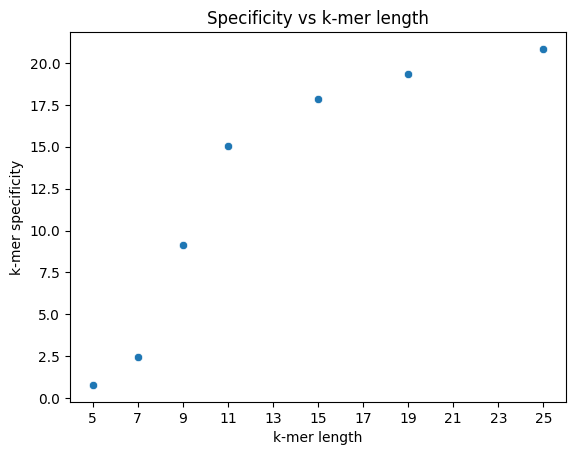

In [19]:
fig, ax = plt.subplots()
ax.set_title("Specificity vs k-mer length")
ax.set_xlabel("k-mer length")
ax.set_xticks(range(5,27,2))
ax.set_ylabel("k-mer specificity")
sns.scatterplot(x=k_list, y=[val[0] for val in k_dict.values()])
plt.show()

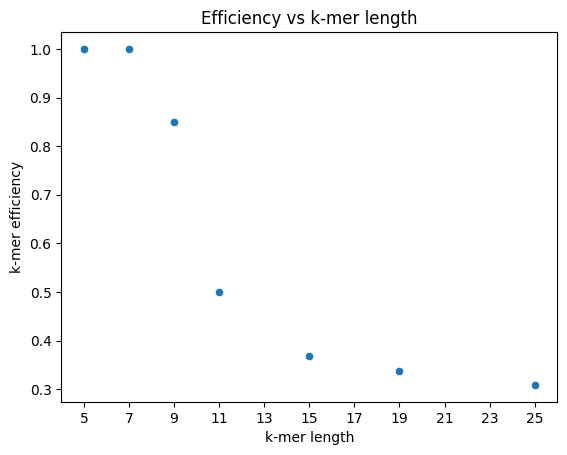

In [20]:
fig, ax = plt.subplots()
ax.set_title("Efficiency vs k-mer length")
ax.set_xlabel("k-mer length")
ax.set_xticks(range(5,27,2))
ax.set_ylabel("k-mer efficiency")
sns.scatterplot(x=k_list, y=[val[1] for val in k_dict.values()])
plt.show()